### Imports

In [3]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines

mpl.rc('font', family='serif', size=22)
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
mpl.rcParams['font.size'] = 22
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['xtick.color'] = '#575757'
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['ytick.color'] = '#575757'

import io
import itertools
from labellines import *

from scipy.optimize import minimize
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
import corner

import astropy.units as u
from astropy.table import Table

In [2]:
from platform import python_version

print(python_version())

3.6.4


Make a custom colormap for $P_{\rm orb}$

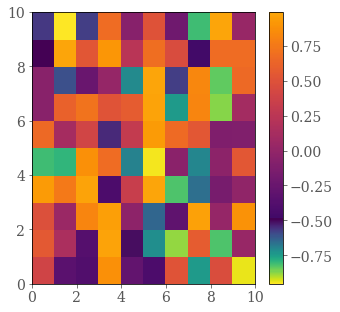

In [4]:
import matplotlib.colors as mcolors

plt.figure(figsize=(5,5))

data = np.random.rand(10,10) * 2 - 1

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.viridis_r(np.linspace(0., 1, 62))
colors2 = plt.cm.inferno(np.linspace(0.2, 0.8, 194))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cv_map = mcolors.LinearSegmentedColormap.from_list('all_cvmap', colors)

# now create a map for the period gap
gap_map = mcolors.LinearSegmentedColormap.from_list('gap_cvmap', cv_map(np.linspace(0.143, 0.294, 256)))

plt.pcolor(data, cmap=cv_map)
plt.colorbar()

Make a custom colormap for $G_{\rm BP}$ count https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

In [5]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

In [6]:
def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

hex_list = ['#ffffff', '#ff8c64','#610061']
obs_map = get_continuous_cmap(hex_list)

## RK16 --> *Gaia* Crossmatch

I propagated a 20" *Gaia* match backwards to J2000.00 using `epoch_prop_pos` in the default *Gaia* Archive ADQL functions. I then crossmatched this to RK16 with a 5" radius. Here I take the *Gaia* neighborhood around each RK16-Gaia crossmatch to remove any sources that have neighbors within 5".

In [7]:
xmatch_df = pd.read_csv('data/rk_edr3_xmatch.csv')

In [8]:
xmatch_df.columns

Index(['rk_edr3_allsources_oid', 'dist', 'rk2gaiaedr3_epoch_prop_oid',
       'source_id', 'ra_gaia_to_rk', 'dec_gaia_to_rk', 'rkj2000_oid', 'name',
       'orb_per', 'ra_j2000',
       ...
       'dr2_bp_rp', 'dr2_phot_g_mean_flux', 'dr2_phot_g_mean_flux_error',
       'dr2_phot_bp_mean_flux', 'dr2_phot_bp_mean_flux_error',
       'dr2_phot_rp_mean_flux', 'dr2_phot_rp_mean_flux_error',
       'dr2_phot_g_n_obs', 'dr2_phot_bp_n_obs', 'dr2_phot_rp_n_obs'],
      dtype='object', length=130)

In [9]:
neighbors_df = pd.read_csv('data/rk_neighborhood.csv')

In [10]:
neighbors_df.columns

Index(['name', 'source_id', 'dist_arcsec'], dtype='object')

In [11]:
singles_df = neighbors_df.drop_duplicates(subset='name', keep=False)

In [12]:
len(singles_df)

971

We limit the RK-Gaia crossmatch to: 
1. Objects that have no neighbors within 5"
2. 1.1 hr < $P_{orb}$ < 8 hr
3. `parallax_over_error` > 8
4. `phot_g_mean_flux_over_error` > 10
4. `astrometric_n_good_obs_al` > 8

In [13]:
rk_df = xmatch_df.loc[(xmatch_df['source_id'].isin(singles_df['source_id'])) & 
                      (xmatch_df['orb_per']*24 < 8) & (xmatch_df['orb_per']*24 > 1.17) &
                      (xmatch_df['parallax_over_error'] > 8) & 
                      (xmatch_df['phot_g_mean_flux_over_error'] > 10) &
                      (xmatch_df['astrometric_n_good_obs_al'] > 8) ]

In [14]:
len(rk_df)

536

Check if there are any ambiguated sources between DR2 and DR3.

In [15]:
len(rk_df.drop_duplicates(subset='source_id', keep=False))

536

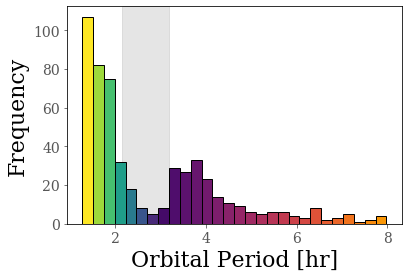

In [16]:
n, bins, patches = plt.hist(rk_df['orb_per']*24, bins=28,
                            fc='Tomato', ec='k')
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cv_map(i/28))

plt.xlabel('Orbital Period [hr]', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
plt.axvspan(2.15, 3.18, alpha=0.2, color='Grey', zorder=0)

## Fit a Linear Regression to the $P_{orb}$-CMD Relationship

Linear regression follows the general form of $Y=\beta X$, where $X$ is a matrix populated by columns of observables, and $\beta$ are the regression coefficients.

We'll be following this general model, using `pymc3`:
$P_{orb} \sim \beta_0 + \beta_X M_G + \beta_Y (G_{BP}-G_{RP}) + \beta_{XY} M_G \cdot (G_{BP}-G_{RP})$ 
Using `pymc3`, we model each $X_i$ as an independent variable in order to incorporate its uncertainty. We divide each observable by the sample median in order to allow for more accurate regression calculation.

In [17]:
p_orb = rk_df['orb_per']*24
abs_g = rk_df['phot_g_mean_mag'] - 5*np.log10(rk_df['r_med_geo']) + 5
bp_rp = rk_df['bp_rp']

p_orb_med = np.median(p_orb)
abs_g_med = np.median(abs_g)
bp_rp_med = np.median(bp_rp)

In [18]:
p_orb_norm = p_orb/p_orb_med
abs_g_norm = abs_g/abs_g_med
bp_rp_norm = bp_rp/bp_rp_med

In [19]:
g_err = 1.086 * rk_df['phot_g_mean_flux_error']/rk_df['phot_g_mean_flux']
bp_err = 1.086 * rk_df['phot_bp_mean_flux_error']/rk_df['phot_bp_mean_flux']
rp_err = 1.086 * rk_df['phot_rp_mean_flux_error']/rk_df['phot_rp_mean_flux']

bp_rp_err = np.sqrt(bp_err**2 + rp_err**2)

abs_g_uplim = 1.086 * np.sqrt((2*(rk_df['r_med_geo']-rk_df['r_lo_geo'])/rk_df['r_med_geo'])**2 + g_err**2)
abs_g_lowlim = 1.086 * np.sqrt((2*(rk_df['r_hi_geo']-rk_df['r_med_geo'])/rk_df['r_med_geo'])**2 + g_err**2)

abs_g_geom_err = np.sqrt((abs_g_uplim)**2 + 
                         (abs_g_lowlim)**2)

Calculate MLE estimates of each prior.

In [20]:
np.random.seed(42)

def ln_like(theta, x_obs, xerr, y_obs, yerr, z_obs):
    beta_0, beta_x, beta_y, beta_xy = theta
    model = p_orb_med * beta_0 * np.exp(beta_x*(x_obs/bp_rp_med) 
                                        + beta_y*(y_obs/abs_g_med)
                                        + beta_xy*(x_obs/bp_rp_med)*(y_obs/abs_g_med)
                                       )
    
    uncertainties = np.sqrt(xerr**2 + yerr**2)
    
    ln_z = -0.5 * np.sum(((z_obs - model) / uncertainties)**2 + np.log(2*np.pi) + np.log(uncertainties))
    
    return ln_z

nll = lambda *args: -ln_like(*args)
initial = np.repeat(0.0,4) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial, args=(bp_rp, bp_rp_err, 
                                    abs_g, abs_g_geom_err, 
                                    p_orb), method='BFGS')
beta_0_ml, beta_x_ml, beta_y_ml, beta_xy_ml = soln.x

Use MLE estimates to initialize MCMC model.

In [21]:
with pm.Model() as edr3_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", sd=1) 
    b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
    bX = pm.Normal("beta_bprp", beta_x_ml, sigma=10)
    bY = pm.Normal("beta_absg", beta_y_ml, sigma=10)
    bXY = pm.Normal("beta_xterm", beta_xy_ml, sigma=10)
    
    # Set X_i as RVs to incorporate their uncertainty
    obs_abs_g = pm.Normal('obs_abs_g', mu=abs_g_norm, sd=abs_g_geom_err, 
                          shape=len(abs_g_norm))
    obs_bp_rp = pm.Normal('obs_bp_rp', mu=bp_rp_norm, sd=bp_rp_err, 
                          shape=len(bp_rp_norm))

    # Define linear model
    y_est = b0 * np.exp(bX*obs_bp_rp + bY*obs_abs_g +
                        bXY*(obs_bp_rp*obs_abs_g))

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=p_orb_norm
    )
    
    edr3_trace = pm.sample(10000, cores=3, target_accept=0.9,
                              return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [nu, obs_bp_rp, obs_abs_g, beta_xterm, beta_absg, beta_bprp, intercept, sigma]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 431 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [42]:
# with pm.Model() as model: 
#     # Define priors
#     sigma = pm.HalfNormal("sigma", sd=1) 
#     b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
#     bX = pm.Normal("beta_bprp", beta_x_ml, sigma=10)
#     bY = pm.Normal("beta_absg", beta_y_ml, sigma=10)
#     bXY = pm.Normal("beta_xterm", beta_xy_ml, sigma=10)
    
#     # Set X_i as RVs to incorporate their uncertainty
#     obs_abs_g = pm.Normal('obs_abs_g', mu=abs_g_norm, sd=abs_g_geom_err, 
#                           shape=len(abs_g_norm))
#     obs_bp_rp = pm.Normal('obs_bp_rp', mu=bp_rp_norm, sd=bp_rp_err, 
#                           shape=len(bp_rp_norm))

#     # Define likelihood
#     likelihood = pm.Normal("p_orb", 
#                            mu = b0 * np.exp(bX*obs_bp_rp + bY*obs_abs_g 
#                                             + bXY*(obs_bp_rp*obs_abs_g)),
#                            sigma=sigma, observed=p_orb_norm)

#     # Inference!
#     trace = pm.sample(10000, cores=3, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [obs_bp_rp, obs_abs_g, beta_xterm, beta_absg, beta_bprp, intercept, sigma]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 227 seconds.
There were 738 divergences after tuning. Increase `target_accept` or reparameterize.
There were 690 divergences after tuning. Increase `target_accept` or reparameterize.
There were 321 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
del(fig)

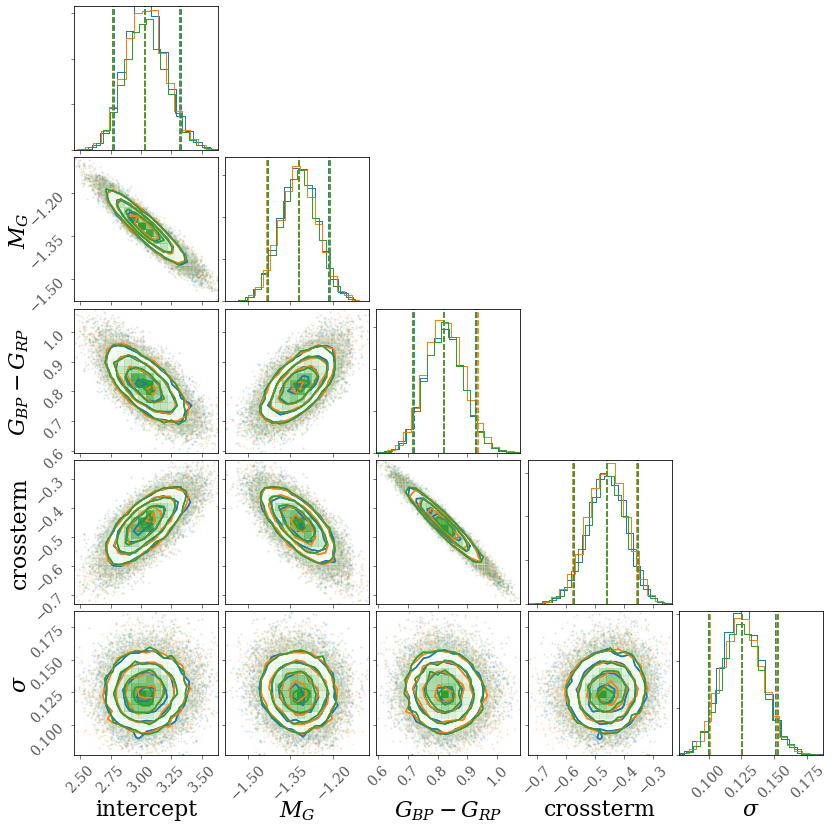

In [23]:
fig = corner.corner(np.vstack((edr3_trace.get_values('intercept', chains=0),
                               edr3_trace.get_values('beta_absg', chains=0), 
                               edr3_trace.get_values('beta_bprp', chains=0), 
                               edr3_trace.get_values('beta_xterm', chains=0),
                               edr3_trace.get_values('sigma', chains=0))).T, 
                    labels = ['intercept', '$M_G$', 
                              '$G_{BP}-G_{RP}$', 'crossterm',
                              '$\sigma$'], color='#1f77b4',
                    alpha=0.25, fig=fig,
                    label_kwargs={"fontsize": 22, "labelpad": 5}, 
                    quantiles=[0.05, 0.5, 0.95])

corner.corner(np.vstack((edr3_trace.get_values('intercept', chains=1),
                         edr3_trace.get_values('beta_absg', chains=1), 
                         edr3_trace.get_values('beta_bprp', chains=1), 
                         edr3_trace.get_values('beta_xterm', chains=1),
                         edr3_trace.get_values('sigma', chains=1))).T,
              fig=fig, color='#ff7f0e', alpha=0.25,
              quantiles=[0.05, 0.5, 0.95])

corner.corner(np.vstack((edr3_trace.get_values('intercept', chains=2),
                         edr3_trace.get_values('beta_absg', chains=2), 
                         edr3_trace.get_values('beta_bprp', chains=2), 
                         edr3_trace.get_values('beta_xterm', chains=2),
                         edr3_trace.get_values('sigma', chains=2))).T,
              fig=fig, color='#2ca02c', alpha=0.25,
              quantiles=[0.05, 0.5, 0.95])

We take the median and 95% confidence interval as the measurement and uncertainty for each $\beta$ parameter. Since all parameters look reasonably converged, we'll treat the uncertainty as symmetric.

In [24]:
with edr3_model:
    display(az.summary(edr3_trace, round_to=2).loc[['intercept', 'beta_absg', 'beta_bprp', 
                                                       'beta_xterm', 'sigma'], :])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,3.04,0.17,2.72,3.35,0.0,0.0,13405.16,10298.61,1.0
beta_absg,-1.32,0.07,-1.45,-1.20,0.0,0.0,14162.97,18826.07,1.0
beta_bprp,0.82,0.06,0.70,0.94,0.0,0.0,8386.89,15155.76,1.0
beta_xterm,-0.46,0.07,-0.58,-0.33,0.0,0.0,9068.87,15245.54,1.0
sigma,0.13,0.02,0.10,0.16,0.0,0.0,3921.36,5725.31,1.0


In [25]:
beta0 = np.median(edr3_trace['intercept'])
betaX = np.median(edr3_trace['beta_absg'])
betaY = np.median(edr3_trace['beta_bprp'])
betaXY = np.median(edr3_trace['beta_xterm'])
sigma_hat = np.median(edr3_trace['sigma'])

beta0_sig = np.percentile(edr3_trace['intercept'], 95) - beta0
betaX_sig = np.percentile(edr3_trace['beta_absg'], 95) - betaX
betaY_sig = np.percentile(edr3_trace['beta_bprp'], 95) - betaY
betaXY_sig = np.percentile(edr3_trace['beta_xterm'], 95) - betaXY

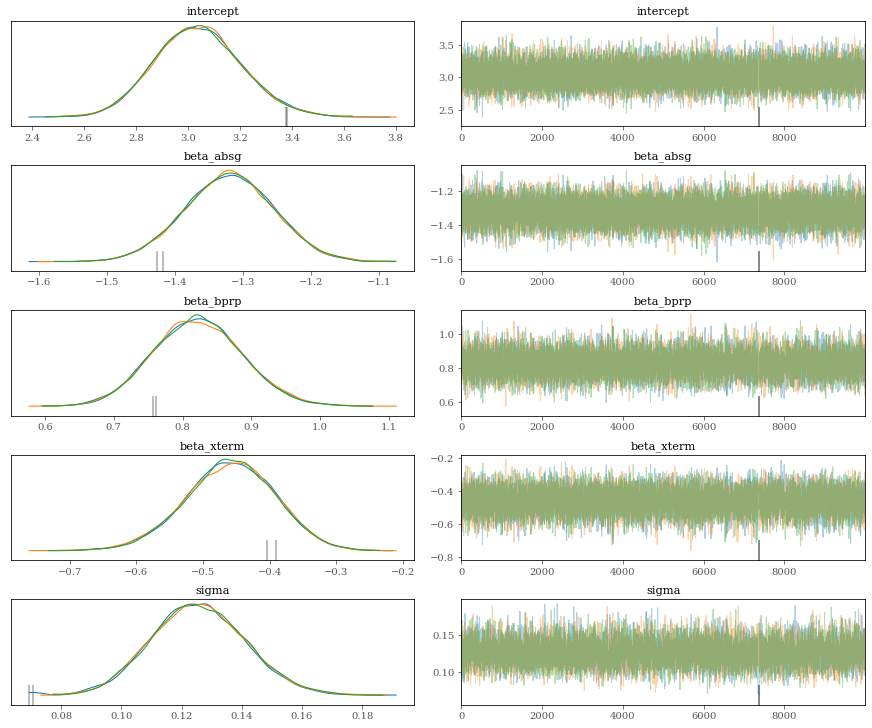

In [26]:
with edr3_model:
    az.plot_trace(edr3_trace, 
                  var_names=['intercept', 'beta_absg', 
                             'beta_bprp', 'beta_xterm', 
                             'sigma'], 
                  combined=False, compact=False)

These plots all show a convincingly converged fit, pointing to $P_{orb}$ being dependent on luminosity in the $G$ band and $G_{BP}-G_{RP}$ colors.

## Visualizing the Linear Fit on the *Gaia* CMD

We use a background sample of nearby *Gaia* stars to illustrate the location of the Main Sequence and White Dwarf Sequence on the cmd.

In [27]:
hey_neighbor_df = pd.read_csv('data/150_pc_clean_edr3.csv')

In [28]:
nearby_distance = 1e3/hey_neighbor_df['parallax']
nearby_g = hey_neighbor_df['phot_g_mean_mag']
nearby_bp_rp = hey_neighbor_df['bp_rp']
nearby_absg = nearby_g - 5*np.log10(nearby_distance) + 5

Our fit interpolates across the optical color bounds and $M_G$ bounds of the RK16 Catalog. We simulate the span of the fit across the bounds.

In [29]:
res = 50

bp_rp_sim = np.linspace(-0.5, 2.75, res)
abs_g_sim = np.linspace(14, 1.5, res)

Text(0, 0.5, '$M_G$')

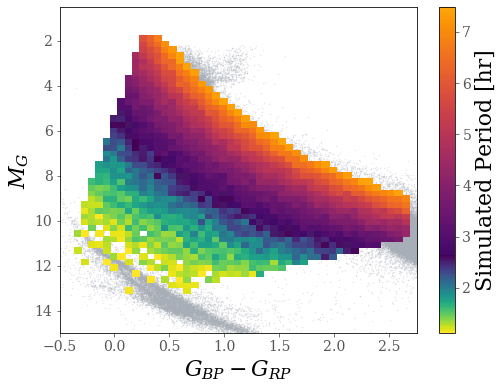

In [30]:
period_grid = np.ones((res, res))

#this for-loop goes through jj first and then ii
for ii in range(res):
    for jj in range(res):
        #jj is x value (row index), ii is y value (column index)
        var = np.random.normal(0, sigma_hat, 1)
        period_grid[ii, jj] = p_orb_med * beta0 * np.exp(betaY*((bp_rp_sim[jj])/bp_rp_med) +
                                                         betaX*((abs_g_sim[ii])/abs_g_med) +
                                                         betaXY*((bp_rp_sim[jj])/bp_rp_med)*((abs_g_sim[ii])/abs_g_med)
                                                        ) + var
                                             

plt.figure(figsize=(8,6))
color = bp_rp_sim
mag = abs_g_sim
X,Y = np.meshgrid(color,mag)

Z = period_grid

Z = np.ma.masked_where((Z > 7.5), Z)
Z = np.ma.masked_where((Z < 1.1), Z)
Z = np.ma.masked_where((Y < 2), Z)
Z = np.ma.masked_where((Y > 13.3), Z)
Z = np.ma.masked_where((X < -0.4), Z)
Z = np.ma.masked_where((X > 2.68), Z)
Z = np.ma.masked_where((Y < -14.29*X + 5), Z) 
Z = np.ma.masked_where((Y > -1.17*X + 14), Z)


cmap = plt.cm.viridis_r
cmap.set_bad(color='black', alpha=0.0)

plt.scatter(nearby_bp_rp, nearby_absg, marker='.', c='#a8aeb7', alpha=0.3, s=1, zorder=-1)

cb = plt.pcolormesh(X,Y,Z, cmap=cv_map)
plt.colorbar(cb, label='Simulated Period [hr]')

plt.xlim(-0.5, 2.75)
plt.ylim(15, 0.5)
plt.xlabel('$G_{BP} - G_{RP}$', fontsize=22)
plt.ylabel('$M_G$', fontsize=22)

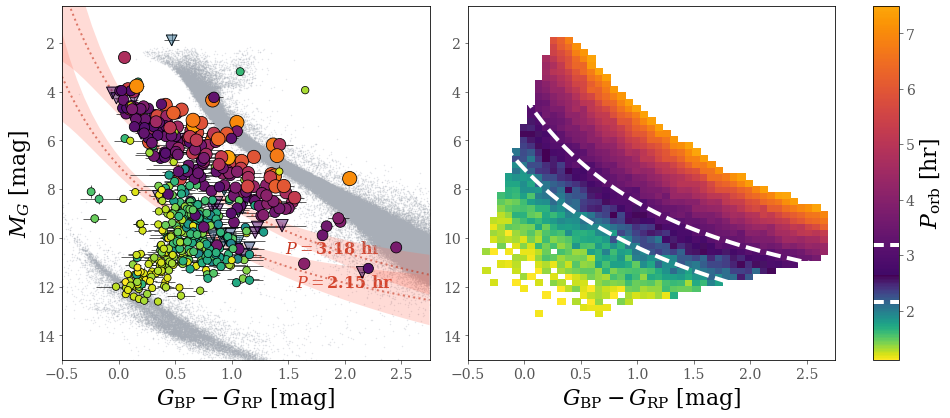

In [32]:
fig, (ax, ax2, cax) = plt.subplots(ncols=3,figsize=(15, 6.5), 
                                   gridspec_kw={"width_ratios":[1, 1, 0.07]})

#Left Subplot

fig.subplots_adjust(wspace=0.15)

ax.scatter(nearby_bp_rp, nearby_absg, marker='.', 
           c='#a8aeb7', alpha=0.3, s=1, zorder=1, rasterized=True)

ax.errorbar(bp_rp, abs_g, 
            yerr=[abs_g_lowlim, abs_g_uplim], 
            xerr=bp_rp_err, fmt='none',
            color='k', 
            linewidth=0.6)

gap_mask = (p_orb > 2.15) & (p_orb < 3.18)

ax.scatter(bp_rp.loc[gap_mask], abs_g.loc[gap_mask], 
           c=p_orb.loc[gap_mask], cmap=gap_map, 
           marker='v', alpha=0.5,
           s=(p_orb.loc[gap_mask]**(1/1.25))*60, 
           zorder=6)

ax.scatter(bp_rp.loc[gap_mask], abs_g.loc[gap_mask], 
           c='none', edgecolor='k', 
           linewidth=0.75, marker='v',
           s=(p_orb.loc[gap_mask]**(1/1.25))*60, 
           zorder=6)

ax.scatter(bp_rp.loc[~gap_mask], abs_g.loc[~gap_mask], 
           c=p_orb.loc[~gap_mask], cmap=cv_map, 
           edgecolor='k', linewidth=0.75, 
           s=(p_orb.loc[~gap_mask]**(1/1.25))*40, 
           zorder=7)

#Period Sequences
color = '#ff725c'

for ii in [2.15,3.18]:
    
    absg_fits = abs_g_med * ((np.log(ii/(p_orb_med*edr3_trace['intercept'][:, None])) \
                              - edr3_trace['beta_bprp'][:, None]*bp_rp_sim/bp_rp_med)/(edr3_trace['beta_absg'][:, None] \
                              + edr3_trace['beta_xterm'][:, None]*bp_rp_sim/bp_rp_med)
                            )
        
    absg_mu = absg_fits.mean(0)
    absg_sig = absg_fits.std(0)
        
    ax.plot(bp_rp_sim, absg_mu, c='#c7351e', linestyle=':', linewidth=2,
            label='$P=${} hr'.format(np.round(ii, 2)), alpha=0.6)
    
    ax.fill_between(bp_rp_sim, absg_mu - 3*absg_sig, absg_mu + 3*absg_sig, 
                    facecolor=color, alpha=0.25)
    
labelLines(ax.get_lines(), 
           xvals=[2.0, 1.9], fontweight='bold', color='#c7351e',
           size=16, align=False, zorder=0)


ax.set_xlim(-0.5, 2.75)
ax.set_ylim(15, 0.5)
ax.set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$ [mag]')
ax.set_ylabel('$M_G$ [mag]')

#------------------------------------------------------------------

#Right Subplot

cb = ax2.pcolormesh(X,Y,Z, cmap=cv_map, zorder=0)
color = '#ffffff'

for ii in [2.15,3.18]:
    absg_fits = abs_g_med * ((np.log(ii/(p_orb_med*edr3_trace['intercept'][:, None])) - edr3_trace['beta_bprp'][:, None]*bp_rp_sim/bp_rp_med)/
                             (edr3_trace['beta_absg'][:, None] + edr3_trace['beta_xterm'][:, None]*bp_rp_sim/bp_rp_med)
                            )
    
    absg_mu = absg_fits.mean(0)
    absg_sig = absg_fits.std(0)
        
    if ii == 2.15:

        ax2.plot(bp_rp_sim, absg_mu + absg_sig, c=color, linestyle='--', linewidth=4, 
                 label='$P=${} hr'.format(np.round(ii, 2)))
        
    else:
        ax2.plot(bp_rp_sim, absg_mu - absg_sig, c=color, linestyle='--', linewidth=4, 
                 label='$P=${} hr'.format(np.round(ii, 2)))


ax2.set_xlim(-0.5, 2.75)
ax2.set_ylim(15, 0.5)
ax2.set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$ [mag]')

cbax = fig.colorbar(cb, label=r'$P_{\rm orb}$ [hr]', cax=cax, format=mpl.ticker.ScalarFormatter())
cbax.ax.hlines([2.15,3.18], 0, 10, colors = 'white', linewidth = 4, linestyles = '--')

plt.savefig('figures/rk_fit.pdf', bbox_inches = 'tight', pad_inches = 0.15)

Put the white dashed lines on the colorbar to show where the period gap is. Circles (below period gap), triangles (within the gap), squares (above the gap). Make it clear how few sources are triangles. Maybe make within the period gap at lower transparency? Josh showed me how to add extra latex commands in strings (repeat throughout)

In [33]:
p_orb_hat =  p_orb_med * beta0 * np.exp(betaY*(bp_rp/bp_rp_med) +
                                               betaX*(abs_g/abs_g_med) +
                                               betaXY*(bp_rp/bp_rp_med)*(abs_g/abs_g_med))

Limit the predicted values to those within the bounds of the training set.

In [34]:
p_orb_for_est = p_orb.loc[(p_orb_hat < 8) & (p_orb_hat > 1.1)]
p_orb_hat = p_orb_hat.loc[(p_orb_hat < 8) & (p_orb_hat > 1.1)]

We can visualize the distributions of $\hat{P}_{\rm orb}$ for a given measured period in a violin plot, by binning data into observed $P_{\rm orb}$ bins.

In [35]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

/Users/elliannaschwab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


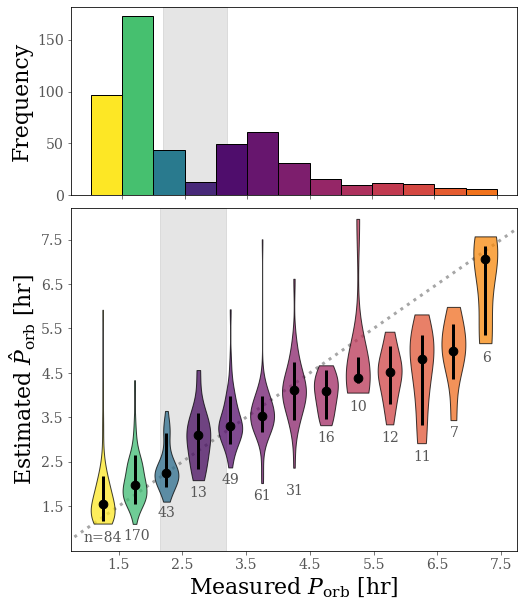

In [110]:
fig, (ax, ax2) = plt.subplots(nrows=2,figsize=(8, 10), 
                                   gridspec_kw={"height_ratios":[0.55, 1]})

#Upper Subplot

n, bins, patches = ax.hist(rk_df['orb_per']*24, bins=np.arange(1.0, 8.0, 0.5),
                            fc='Tomato', ec='k')
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cv_map(i/len(np.arange(1.0, 8.0, 0.5))))

ax.set_ylabel('Frequency', fontsize=22)
ax.axvspan(2.15, 3.18, alpha=0.2, color='Grey', zorder=0)

ax.set_xticks(np.arange(1.5, 8.5, 1))
ax.set_xticklabels(np.repeat('', 7))


#------------------------------------------------------------------

#Lower Subplot


porb_1 = p_orb_hat.loc[(p_orb_for_est >= 1) & (p_orb_for_est < 1.5)]
porb_15 = p_orb_hat.loc[(p_orb_for_est >= 1.5) & (p_orb_for_est < 2)]
porb_2 = p_orb_hat.loc[(p_orb_for_est >= 2) & (p_orb_for_est < 2.5)]
porb_25 = p_orb_hat.loc[(p_orb_for_est >= 2.5) & (p_orb_for_est < 3)]
porb_3 = p_orb_hat.loc[(p_orb_for_est >= 3) & (p_orb_for_est < 3.5)]
porb_35 = p_orb_hat.loc[(p_orb_for_est >= 3.5) & (p_orb_for_est < 4)]
porb_4 = p_orb_hat.loc[(p_orb_for_est >= 4) & (p_orb < 4.5)]
porb_45 = p_orb_hat.loc[(p_orb >= 4.5) & (p_orb_for_est < 5)]
porb_5 = p_orb_hat.loc[(p_orb_for_est >= 5) & (p_orb_for_est < 5.5)]
porb_55 = p_orb_hat.loc[(p_orb_for_est >= 5.5) & (p_orb_for_est < 6)]
porb_6 = p_orb_hat.loc[(p_orb_for_est >= 6) & (p_orb_for_est < 6.5)]
porb_65 = p_orb_hat.loc[(p_orb_for_est >= 6.5) & (p_orb_for_est < 7)]
porb_7 = p_orb_hat.loc[(p_orb_for_est >= 7) & (p_orb_for_est < 7.5)]

## combine these different collections into a list
violin_bins = np.array([porb_1.values, porb_15.values, porb_2.values, porb_25.values,
                        porb_3.values, porb_35.values, porb_4.values, porb_45.values,
                        porb_5.values, porb_55.values, porb_6.values, porb_65.values,
                        porb_7.values])

bp = ax2.violinplot(violin_bins, widths=0.75,
                    showmeans=False, showmedians=False, 
                    showextrema=False)

colors = [cv_map((1.*i/len(violin_bins))) for i in range(len(violin_bins))]
iter_colors = itertools.cycle(colors)

for pc in bp['bodies']:
    color = list(next(iter_colors))
    color[3]=0.8
    pc.set_facecolor(tuple(color))
    pc.set_edgecolor('k')
    pc.set_alpha(0.75)
    
percentiles=[]   
for ii in range(len(violin_bins)):
    percentiles.append(np.percentile(violin_bins[ii], [12.5, 50, 87.5]))

quartile1, medians, quartile3 = np.array(percentiles)[:,0],np.array(percentiles)[:,1], np.array(percentiles)[:,2]
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(violin_bins, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='k', s=75, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=3)

#these lines define the transformation between xcoord axis and number line
ax2.set_xticks(np.arange(1.5, 15.5, 2))
ax2.set_xticklabels(np.arange(1.5, 8.5, 1))


#transform the gap limits into the x coordinate system
ax2.axvspan(2.80, 4.86, alpha=0.2, color='Grey', zorder=0) 
ax2.plot([-0.5,15.5], [0.5,8.5], c='k', 
         ls=':', lw=3, alpha=0.35,
         zorder=-1) #recast to accomodate x coordinate system

ax2.set_yticks(np.arange(1.5, 8.5, 1))

ax2.set_xlim(0, 14)
ax2.set_ylim(0.5, 8.2)

#annotations
ax2.annotate('n='+str(len(porb_1)), (0.4, 0.7), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_15)), (1.65, 0.75), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_2)), (2.73, 1.25), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_25)), (3.73, 1.7), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_3)), (4.73, 2.), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_35)), (5.73, 1.65), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_4)), (6.74, 1.75), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_45)), (7.74, 2.95), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_5)), (8.74, 3.65), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_55)), (9.74, 2.95), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_6)), (10.74, 2.52), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_65)), (11.9, 3.05), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_7)), (12.9, 4.75), fontsize=14, c='#575757')

ax2.set_xlabel(r'Measured $P_{\rm orb}$ [hr]')
ax2.set_ylabel(r'Estimated $\hat{P}_{\rm orb}$ [hr]')

plt.subplots_adjust(hspace=0.05)

plt.savefig('figures/rk_gof.pdf', bbox_inches = 'tight', pad_inches = 0.15)

## The $P_{orb}$-CMD Relationship in DR2

We'll investigate how much the relationship has changed as a function of sample size, *i.e.* of *Gaia* data release number. This will depend on how much the CMD position of each CV has changed from survey to survey as dependent on time-averaged photometry and **not** astrometry, since we do expect each CV to vary photometrically over time but not in distance. Therefore, we'll use the more precise DR3 positions.

In [37]:
dr2_rk_df = rk_df.loc[np.isfinite(rk_df['dr2_bp_rp'])]

In [38]:
len(dr2_rk_df)

534

In [39]:
dr2_p_orb = dr2_rk_df['orb_per']*24
dr2_abs_g = dr2_rk_df['dr2_phot_g_mean_mag'] - 5*np.log10(dr2_rk_df['r_med_geo']) + 5
dr2_bp_rp = dr2_rk_df['dr2_bp_rp']

dr2_p_orb_med = np.median(dr2_p_orb)
dr2_abs_g_med = np.median(dr2_abs_g)
dr2_bp_rp_med = np.median(dr2_bp_rp)

dr2_p_orb_norm = dr2_p_orb/p_orb_med
dr2_abs_g_norm = dr2_abs_g/dr2_abs_g_med
dr2_bp_rp_norm = dr2_bp_rp/dr2_bp_rp_med

In [40]:
dr2_g_err = 1.086 * dr2_rk_df['dr2_phot_g_mean_flux_error']/dr2_rk_df['dr2_phot_g_mean_flux']
dr2_bp_err = 1.086 * dr2_rk_df['dr2_phot_bp_mean_flux_error']/dr2_rk_df['dr2_phot_bp_mean_flux']
dr2_rp_err = 1.086 * dr2_rk_df['dr2_phot_rp_mean_flux_error']/dr2_rk_df['dr2_phot_rp_mean_flux']

dr2_bp_rp_err = np.sqrt(dr2_bp_err**2 + dr2_rp_err**2)

dr2_abs_g_uplim = 1.086 * np.sqrt((2*(dr2_rk_df['r_med_geo']-dr2_rk_df['r_lo_geo'])/dr2_rk_df['r_med_geo'])**2 + dr2_g_err**2)
dr2_abs_g_lowlim = 1.086 * np.sqrt((2*(dr2_rk_df['r_hi_geo']-dr2_rk_df['r_med_geo'])/dr2_rk_df['r_med_geo'])**2 + dr2_g_err**2)

dr2_abs_g_geom_err = np.sqrt((dr2_abs_g_uplim)**2 + 
                             (dr2_abs_g_lowlim)**2)

As above, we calculate MLE estimates of the prior.

In [41]:
soln = minimize(nll, initial, args=(dr2_bp_rp, dr2_bp_rp_err, 
                                    dr2_abs_g, dr2_abs_g_geom_err, 
                                    dr2_p_orb), method='BFGS')
dr2_beta_0_ml, dr2_beta_x_ml, dr2_beta_y_ml, dr2_beta_xy_ml = soln.x

In [42]:
np.isfinite(dr2_bp_rp_err).all()

True

In [43]:
with pm.Model() as dr2_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", sd=1) 
    b0 = pm.Normal("intercept", dr2_beta_0_ml, sigma=10)
    bX = pm.Normal("beta_bprp", dr2_beta_x_ml, sigma=10)
    bY = pm.Normal("beta_absg", dr2_beta_y_ml, sigma=10)
    bXY = pm.Normal("beta_xterm", dr2_beta_xy_ml, sigma=10)
    
    # Set X_i as RVs to incorporate their uncertainty
    obs_abs_g = pm.Normal('obs_abs_g', mu=dr2_abs_g_norm, sd=dr2_abs_g_geom_err, 
                          shape=len(dr2_abs_g_norm))
    obs_bp_rp = pm.Normal('obs_bp_rp', mu=dr2_bp_rp_norm, sd=dr2_bp_rp_err, 
                          shape=len(dr2_bp_rp_norm))

    # Define linear model
    y_est = b0 * np.exp(bX*obs_bp_rp + bY*obs_abs_g 
                        + bXY*(obs_bp_rp*obs_abs_g))

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=dr2_p_orb_norm
    )
    
    dr2_trace = pm.sample(10000, cores=3, target_accept=0.8,
                          return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [nu, obs_bp_rp, obs_abs_g, beta_xterm, beta_absg, beta_bprp, intercept, sigma]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 283 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 414 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.699360963433794, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [44]:
with dr2_model:
    display(az.summary(dr2_trace, round_to=2).loc[['intercept', 'beta_absg', 'beta_bprp', 
                                                       'beta_xterm', 'sigma'], :])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,3.25,0.17,2.92,3.57,0.0,0.0,1606.68,4349.71,1.00
beta_absg,-1.38,0.06,-1.49,-1.26,0.0,0.0,1507.61,4602.86,1.00
beta_bprp,0.74,0.06,0.64,0.85,0.0,0.0,1568.08,3572.10,1.00
beta_xterm,-0.39,0.06,-0.50,-0.29,0.0,0.0,1192.75,3655.41,1.00
sigma,0.12,0.02,0.09,0.15,0.0,0.0,333.97,141.58,1.01


For comparison, these are the numbers from EDR3:

In [45]:
with edr3_model:
    display(az.summary(edr3_trace, round_to=2).loc[['intercept', 'beta_absg', 'beta_bprp', 
                                                       'beta_xterm', 'sigma'], :])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,3.04,0.17,2.72,3.35,0.0,0.0,13405.16,10298.61,1.0
beta_absg,-1.32,0.07,-1.45,-1.20,0.0,0.0,14162.97,18826.07,1.0
beta_bprp,0.82,0.06,0.70,0.94,0.0,0.0,8386.89,15155.76,1.0
beta_xterm,-0.46,0.07,-0.58,-0.33,0.0,0.0,9068.87,15245.54,1.0
sigma,0.13,0.02,0.10,0.16,0.0,0.0,3921.36,5725.31,1.0


These coefficients are remarkably similar, and equivalent within their confidence intervals.

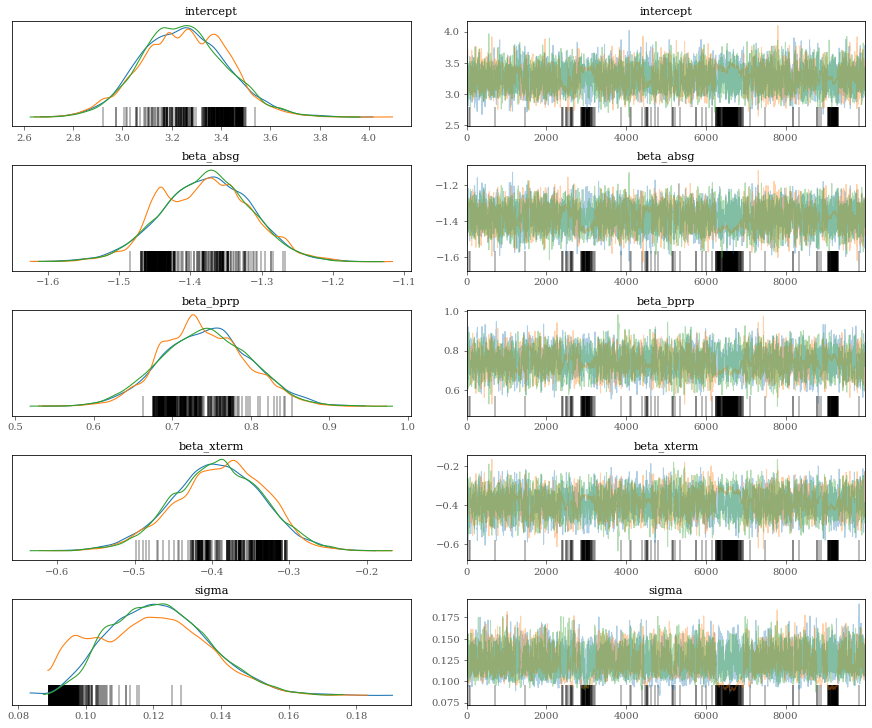

In [46]:
with dr2_model:
    az.plot_trace(dr2_trace, 
                  var_names=['intercept', 'beta_absg', 
                             'beta_bprp', 'beta_xterm', 
                             'sigma'], 
                  combined=False, compact=False)

If we compare the corner plots of the coefficients between DR2 and EDR3, we get the following:

In [109]:
del(fig2)

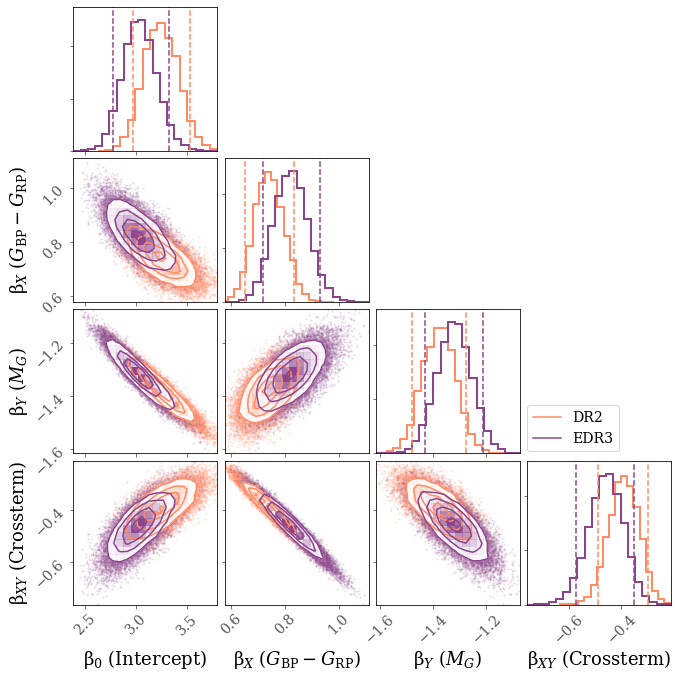

In [47]:
dr2_line = mlines.Line2D([], [], color='#FF8C64', label='DR2')
edr3_line = mlines.Line2D([], [], color='#8c458c', label='EDR3')

fig2 = corner.corner(np.vstack((dr2_trace['intercept'],
                                dr2_trace['beta_bprp'],
                                dr2_trace['beta_absg'],  
                                dr2_trace['beta_xterm'])).T, 
                     labels = ['β$_0$ (Intercept)', r'β$_X$ ($G_{\rm BP}-G_{\rm RP}$)',
                               'β$_Y$ ($M_G$)', 'β$_{XY}$ (Crossterm)'], 
                     color='#FF8C64', hist_kwargs=dict(linewidth=2),
                     data_kwargs=dict(alpha=0.2), #fig=fig2,
                     label_kwargs={"fontsize": 18, "labelpad": 5}, 
                     max_n_ticks=3, plot_contours=True,
                     quantiles=[0.05,0.95], zorder=0)

corner.corner(np.vstack((edr3_trace['intercept'],
                         edr3_trace['beta_bprp'],
                         edr3_trace['beta_absg'], 
                         edr3_trace['beta_xterm'])).T,
              fig=fig2, color='#8c458c', #'#8F338C',
              data_kwargs=dict(alpha=0.2),
              hist_kwargs=dict(linewidth=2),
              max_n_ticks=3, plot_contours=True,
              quantiles=[0.05,0.95], zorder=1)

plt.legend(handles=[dr2_line,edr3_line], 
           bbox_to_anchor=(0., 1.015, 0.685, .0), 
           loc=4, prop={'size': 14})

plt.savefig('figures/release_posteriors.pdf', bbox_inches = 'tight', pad_inches = 0.15)

## CMD Position as a Function of *Gaia* Release Number

Talk to Paula and Lars about what discussion points are useful here. Might be worth coloring according to sample count (*i.e.* photometric points used)? The interesting thing about the color change is that might contain info about the disk.

Given that the *Gaia* color span of RK16 is ~2.5 in $G_{BP}-G_{RP}$ space, we consider something having moved significantly on the CMD when its color has changed by more than 0.25, or 10\% of the CV color space, between releases.

In [48]:
rk_movers = rk_df.loc[np.abs(rk_df['dr2_bp_rp'] - rk_df['bp_rp']) > 0.25].copy()
rk_movers['abs_g'] = rk_movers['phot_g_mean_mag'] - 5*np.log10(rk_movers['r_med_geo']) + 5
rk_movers['dr2_abs_g'] = rk_movers['dr2_phot_g_mean_mag'] - 5*np.log10(rk_movers['r_med_geo']) + 5

In [49]:
print(str(np.round(len(rk_movers)/len(rk_df)*100, 2))+'% of the RK16-Gaia Sample moved more than 10% in color space the CMD.')
print(str(len(rk_movers))+' objects')

4.1% of the RK16-Gaia Sample moved more than 10% in color space the CMD.
22 objects


We check to see how much sampling count makes a difference in this motion -- it turns out not by much.

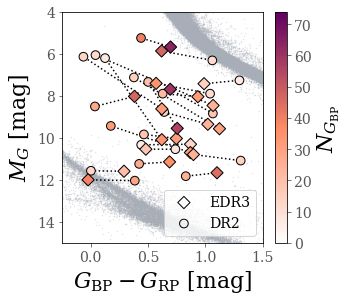

In [50]:
fig = plt.figure(figsize=(4.5,4.25))

plt.scatter(nearby_bp_rp, nearby_absg, marker='.', c='#a8aeb7',
            label='', rasterized=True,
            alpha=0.3, s=1, zorder=-1)


for ii in range(int(len(rk_movers))):
    plt.plot([rk_movers['bp_rp'].iloc[ii], rk_movers['dr2_bp_rp'].iloc[ii]], 
             [rk_movers['abs_g'].iloc[ii], rk_movers['dr2_abs_g'].iloc[ii]], 
             'k.:', label='',zorder=0)
    
cb = plt.scatter(rk_movers['bp_rp'], rk_movers['abs_g'],
                 marker='D', c=rk_movers['phot_bp_n_obs'], 
                 cmap=obs_map, vmin=0, vmax=74,
                 label='EDR3',edgecolor='k', s=75, zorder=3)

plt.scatter(rk_movers['dr2_bp_rp'], rk_movers['dr2_abs_g'],
            marker='o', c=rk_movers['dr2_phot_bp_n_obs'], 
            cmap=obs_map, vmin=0, vmax=74,
            label='DR2',edgecolor='k', s=75, zorder=2)

cbar = plt.colorbar(cb, label=r'$N_{G_{\rm BP}}$')

leg = plt.legend(loc='lower right', prop={'size':14})
leg.legendHandles[0].set_facecolor('None')
leg.legendHandles[1].set_facecolor('None')

plt.xlim(-0.25, 1.5)
plt.ylim(15, 4)

plt.xticks(np.arange(0, 1.75, 0.5))

plt.xlabel(r'$G_{\rm BP}-G_{\rm RP}$ [mag]')
plt.ylabel('$M_G$ [mag]')

plt.savefig('figures/movers.pdf', bbox_inches = 'tight', pad_inches = 0.15)

## The Semi-Empirical Donor Sequence in EDR3

Bring in the NIR data from the *Gaia* Archive crossmatch.

In [57]:
ir_df = pd.read_csv('data/rk_gaia_nir.csv')

In [58]:
ir_df.columns

Index(['source_id', 'source_id.1', 'original_ext_source_id', 'tmass_oid',
       'number_of_neighbours', 'number_of_mates',
       'best_neighbour_multiplicity', 'tmass_oid.1', 'designation', 'ra',
       'dec', 'j_m', 'j_msigcom', 'h_m', 'h_msigcom', 'ks_m', 'ks_msigcom',
       'j_date', 'source_id.2', 'original_ext_source_id.1', 'allwise_oid',
       'number_of_neighbours.1', 'number_of_mates.1',
       'best_neighbour_multiplicity.1', 'allwise_oid.1', 'designation.1',
       'ra.1', 'dec.1', 'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error',
       'w3mpro', 'w3mpro_error', 'w4mpro', 'w4mpro_error', 'cc_flags',
       'w1mjd_mean', 'w2mjd_mean', 'w3mjd_mean', 'tmass_key'],
      dtype='object')

In [96]:
rk_ir_df = rk_df.loc[p_orb < 6].merge(ir_df, how='left', left_on='dr2_source_id', right_on='source_id')

Process the NIR CMD parameters.

In [97]:
abs_j = rk_ir_df['j_m'] - 5*np.log10(rk_ir_df['r_med_geo']) + 5
abs_j_uplim = 1.086 * np.sqrt((2*(rk_ir_df['r_med_geo']-rk_ir_df['r_lo_geo'])/rk_ir_df['r_med_geo'])**2 + rk_ir_df['j_msigcom']**2)
abs_j_lowlim = 1.086 * np.sqrt((2*(rk_ir_df['r_hi_geo']-rk_ir_df['r_med_geo'])/rk_ir_df['r_med_geo'])**2 + rk_ir_df['j_msigcom']**2)

abs_j_geom_err = np.sqrt((abs_j_uplim)**2 + 
                         (abs_j_lowlim)**2)

Bring in the semi-empirical Donor Sequence from *Knigge et al. 2011*.

In [65]:
donor_seq_table = Table.read('data/knigge11_donorsequence.txt', format='ascii.cds')

In [66]:
donor_seq = donor_seq_table.to_pandas()

Convert the bandpasses from Knigge11 to *Gaia* G, using the relationship provided in the [EDR3 Documentation](https://gea.esac.esa.int/archive/documentation/GEDR3/Data_processing/chap_cu5pho/cu5pho_sec_photSystem/cu5pho_ssec_photRelations.html).

$G - V = -0.15 - 0.5 \cdot (V-R) - 0.32 \cdot (V-R)**2$

In [106]:
# donor_seq_g = -0.0028 + 0.7632*(donor_seq['VMag'] - 
#                                 donor_seq['RMag']) - 0.6894*(donor_seq['VMag'] - 
#                                                              donor_seq['RMag'])**2 + 0.0974*(donor_seq['VMag'] - 
#                                                                                              donor_seq['RMag'])**3 + donor_seq['RMag']

donor_seq_g = -0.15 + 0.5*(donor_seq['VMag'] - 
                           donor_seq['RMag']) - 0.32*(donor_seq['VMag'] - 
                                                      donor_seq['RMag'])**2 + donor_seq['VMag']

/Users/elliannaschwab/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/elliannaschwab/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/elliannaschwab/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


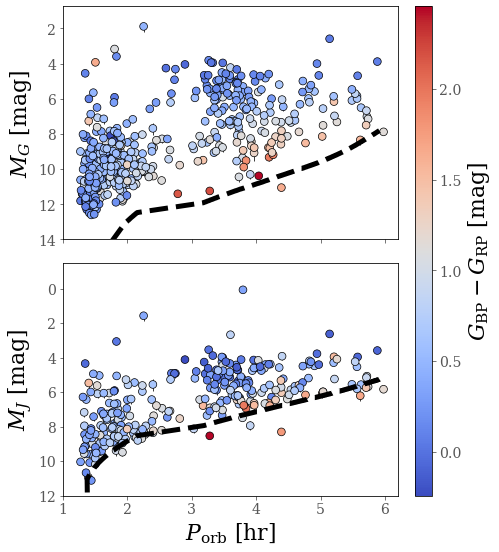

In [107]:
fig, axes = plt.subplots(2, figsize=(6,9), sharex=True)

# Upper Subplot
knigge_mask = p_orb < 6

axes[0].errorbar(p_orb.loc[knigge_mask], abs_g.loc[knigge_mask], 
                 yerr=[abs_g_uplim.loc[knigge_mask], 
                       abs_g_lowlim.loc[knigge_mask]], 
                 fmt='.', c='k', lw=0.75, alpha=1,
                 zorder=0)
cb = axes[0].scatter(p_orb.loc[knigge_mask], 
                     abs_g.loc[knigge_mask], 
                     c=bp_rp.loc[knigge_mask], 
                     cmap='coolwarm', s=60,
                     edgecolor='k', linewidth=0.7,
                     zorder=1)
axes[0].plot(donor_seq['Period'], donor_seq_g, 
             c='k', linewidth=5, linestyle='--')
axes[0].set_ylabel('$M_G$ [mag]')
axes[0].set_ylim(14, 0.75)

#-------------------------------------------

# Lower Subplot
axes[1].errorbar(rk_ir_df['orb_per']*24, abs_j, 
                 yerr=[abs_j_uplim, abs_j_lowlim], 
                 fmt='.', c='k', lw=0.75, alpha=1,
                 zorder=0)
axes[1].scatter(rk_ir_df['orb_per']*24, abs_j, 
                c=rk_ir_df['bp_rp'], 
                cmap='coolwarm', s=60,
                edgecolor='k', linewidth=0.7,
                zorder=1)
axes[1].plot(donor_seq['Period'], donor_seq['JMag'], 
             c='k', linewidth=5, linestyle='--')
axes[1].set_ylabel('$M_J$ [mag]')
axes[1].set_xlim(1, 6.2)
axes[1].set_ylim(12, -1.5)
axes[1].set_xlabel(r'$P_{\rm orb}$ [hr]')

cbar_ax = fig.add_axes([0.94, 0.125, 0.04, 0.755])
fig.colorbar(cb, cax=cbar_ax, label=r"$G_{\rm BP}-G_{\rm RP}$ [mag]")

plt.subplots_adjust(hspace=0.1)
plt.savefig('figures/knigge_donorsequence.pdf', bbox_inches = 'tight', pad_inches = 0.15)

In [103]:
len(abs_j.loc[np.isfinite(abs_j)])

300

## Making a LaTeX Table for the Paper

First, make the RK16-*Gaia* crossmatch table.

In [51]:
rkdf_table = pd.DataFrame({'{\it Gaia} \texttt{source\_id}': rk_df['source_id'], 
                           '\hyperlink{cite.ritter_2003}{RK16} Name': rk_df['name'],
                           '$P_{\rm orb}$': p_orb, '$M_G$': abs_g, 
                           '$G_{\rm BP}-G_{\rm RP}$': bp_rp}).round(decimals=4)

rkdf_table.sort_values(by='$P_{\rm orb}$', inplace=True)

In [52]:
rk_table = Table.from_pandas(rkdf_table)
rk_table.write('tables/rk_xmatch_table.dat', format='ascii.aastex', overwrite=True)

Print out EDR3 and DR2 parameter fits to put into Table 2.

In [53]:
with edr3_model:
    display(az.summary(edr3_trace, hdi_prob = 0.90, round_to=3).loc[['intercept', 'beta_absg', 'beta_bprp', 
                                                                        'beta_xterm', 'sigma'], :])

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,3.040,0.168,2.762,3.309,0.001,0.001,13405.156,10298.614,1.000
beta_absg,-1.321,0.066,-1.429,-1.213,0.001,0.000,14162.969,18826.074,1.000
beta_bprp,0.823,0.065,0.711,0.924,0.001,0.001,8386.892,15155.764,1.000
beta_xterm,-0.460,0.068,-0.569,-0.347,0.001,0.001,9068.872,15245.540,1.000
sigma,0.126,0.016,0.100,0.151,0.000,0.000,3921.364,5725.315,1.001


In [105]:
with dr2_model:
    display(az.summary(dr2_trace, hdi_prob = 0.90, round_to=3).loc[['intercept', 'beta_absg', 'beta_bprp', 
                                                                        'beta_xterm', 'sigma'], :])

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,3.250,0.174,2.970,3.535,0.004,0.003,1606.677,4349.707,1.004
beta_absg,-1.378,0.063,-1.476,-1.272,0.002,0.001,1507.610,4602.863,1.003
beta_bprp,0.742,0.056,0.650,0.834,0.001,0.001,1568.083,3572.096,1.004
beta_xterm,-0.391,0.058,-0.483,-0.295,0.002,0.001,1192.747,3655.409,1.005
sigma,0.121,0.015,0.095,0.144,0.001,0.001,333.974,141.580,1.010
